#### This Python 3 environment comes with many helpful analytics libraries installed
### It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
### For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

### Input data files are available in the read-only "../input/" directory
### For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
### You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm import tqdm_notebook as tqdm # progress bar
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

# torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# sklearn
from sklearn.model_selection import StratifiedKFold

# CV
import cv2

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Glob
from glob import glob

# PIL 
from PIL import Image
from IPython.display import display, Image as IPImage

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Lets check our Hardware first
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Oct 11 17:51:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Configuration Settings

In [4]:
n_folds = 5
seed = 2020
num_classes = 3
BATCH_SIZE = 8
#LR = 0.05

## Use more then 20 Epochs, we go for 20 epochs for demonstration purposes
EPOCHS = 10
img_size_training = 512

## Choose your optimizers:
Adam = False
if Adam: 
    Adam_config = {"lr" : 0.001, "betas" : (0.9, 0.999), "eps" : 1e-08}
else:
    SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.0005}

In [ ]:
num_classes

# Seed Everything

Seeding everything for reproducible results.

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

# Preparing the Data

For creating a cross-validation strategy we use code from Alex's awesome [kernel](https://www.kaggle.com/shonenkov/training-efficientdet).
We will create a cross-validation split in which the folds are made by preserving the percentage of samples (= stratisfied!) for each of the following "classes":
* number of boxes 
* source

For this we first check the data:

In [ ]:
#!rm -R TBX_XML

In [ ]:
%cd ..

In [ ]:
!rm -R TBX_XML

In [6]:
#!mkdir TBX_json
!mkdir TBX_XML
%cd TBX_XML
!mkdir xml
!mkdir orig_images
!mkdir test_data
#!cp -R /kaggle/input/tbx-11/TBX11K/annotations/json/TBX11K_trainval_only_tb.json /kaggle/working/TBX_json

!cp -R /kaggle/input/tbx-11/TBX11K/imgs/tb/* /kaggle/working/TBX_XML/orig_images
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/* /kaggle/working/TBX_XML/xml

/kaggle/working/TBX_XML


In [7]:
import os
%cd /kaggle/working/TBX_XML
os.makedirs('labels/train', exist_ok = True)  #/kaggle/working/TBX_yolo/
os.makedirs('labels/val', exist_ok = True)    #/kaggle/working/TBX_yolo/
os.makedirs('labels/test', exist_ok = True)   #/kaggle/working/TBX_yolo/
os.makedirs('images/train', exist_ok = True)  #/kaggle/working/TBX_yolo/
os.makedirs('images/val', exist_ok = True)    #/kaggle/working/TBX_yolo/
os.makedirs('images/test', exist_ok = True)    #/kaggle/working/TBX_yolo/

/kaggle/working/TBX_XML


In [7]:
import torch
import torchvision.models.detection

num_classes = 3
def get_model():    
    # load pre-trained model incl. head
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier custom head
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [8]:
model = get_model()
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 296MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Load XML data to Dataframe 

In [9]:
import glob

def create_boundbox_df(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(member.find('bndbox').find('xmin').text),
                     int(member.find('bndbox').find('ymin').text),
                     int(member.find('bndbox').find('xmax').text),
                     int(member.find('bndbox').find('ymax').text),
                     
                     member.find('name').text,
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax', 'class_name']
    bbox_df = pd.DataFrame(xml_list, columns=column_name)
    return bbox_df

bbox_df = create_boundbox_df('/kaggle/working/TBX_XML/xml')
bbox_df.head()

filename  width  height  xmin  ymin  xmax  ymax          class_name
0   tb0754   2840    2823  1554   311  2191  1186  ActiveTuberculosis
1   tb0754   2840    2823   842   332  1459  1164  ActiveTuberculosis
2   tb0237   2372    2880   680   389  1131  1077  ActiveTuberculosis
3   tb0859   1753    2022  1040   216  1359   575  ActiveTuberculosis
4   tb0859   1753    2022   220   840   717  1281  ActiveTuberculosis

In [ ]:
RESIZE_TO = 512

width_ratio = 512 / bbox_df.width
height_ratio = 512 / bbox_df.height
width_ratio = width_ratio.rename('width_ratio')
height_ratio = height_ratio.rename('height_ratio')
bbox_df = pd.concat([bbox_df, width_ratio, height_ratio], axis=1)
#bbox_df.head()


true_xmin = bbox_df.xmin * bbox_df.width_ratio
true_ymin = bbox_df.ymin * bbox_df.height_ratio
true_width = (bbox_df.xmax - bbox_df.xmin) * bbox_df.width_ratio
true_height = (bbox_df.ymax - bbox_df.ymin) * bbox_df.height_ratio
true_xmin = true_xmin.rename('true_xmin')
true_ymin = true_ymin.rename('true_ymin')
true_width = true_width.rename('true_width')
true_height = true_height.rename('true_height')


bbox_df = pd.concat([bbox_df, true_xmin, true_ymin, true_width, true_height], axis=1)
bbox_df.head()


In [ ]:
bbox_df.columns = bbox_df.columns.str.replace(' ', '')
bbox_df = bbox_df.rename(columns={'filename': 'image_id'})
# create column image_path

bbox_df['image_path'] = f'/kaggle/working/TBX_XML/orig_images/'+bbox_df.image_id

## Create column class_id

bbox_df.loc[bbox_df['class_name'] == 'ActiveTuberculosis', 'class_id'] =  '1'
bbox_df.loc[bbox_df['class_name'] == 'ObsoletePulmonaryTuberculosis', 'class_id'] =  '2'
bbox_df.loc[:, 'class_id'] = bbox_df['class_id'].astype(int)

bbox_df.head(5)


In [ ]:
 bbox_df = bbox_df[bbox_df[ 'class_id'].isna() == False]

In [ ]:
bbox_df['class_id'] = bbox_df['class_id'].astype(int)

In [ ]:
is_equal = bbox_df['class_id'].astype(int) == bbox_df['class_id']

In [ ]:
print(bbox_df.columns)

In [ ]:
bbox_df.info()

In [ ]:
bbox_df['class_id'].value_counts()

In [ ]:
# BACK UP 
bbox_df_backup = bbox_df
df_train = bbox_df   # Create df_train 

In [ ]:
## MOve Test records , already moved to test folder 

x = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_test = bbox_df[df_train.index.isin(x)]
df_test

In [10]:
# Move data to test

!cp -R /kaggle/working/TBX_XML/orig_images/tb0858.png /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/working/TBX_XML/orig_images/tb0999.png /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/working/TBX_XML/orig_images/tb0915.png /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/working/TBX_XML/orig_images/tb0294.png /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/working/TBX_XML/orig_images/tb0285.png /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/working/TBX_XML/orig_images/tb0787.png /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/working/TBX_XML/orig_images/tb0832.png /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/working/TBX_XML/orig_images/tb0282.png /kaggle/working/TBX_XML/test_data
#!cp -R /kaggle/working/TBX_XML/orig_images/tb0843.png /kaggle/working/TBX_XML/test_data

# MOVE XML

!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/tb0858.xml /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/tb0999.xml /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/tb0915.xml /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/tb0294.xml /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/tb0285.xml /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/tb0787.xml /kaggle/working/TBX_XML/test_data
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/tb0832.xml /kaggle/tb0285working/TBX_XML/test_data
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/tb0282.xml /kaggle/working/TBX_XML/test_data
#!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/tb0843.xml /kaggle/working/TBX_XML/test_data


cp: cannot create regular file '/kaggle/tb0285working/TBX_XML/test_data': No such file or directory


#### Drop records from bbox df or training set

In [ ]:
#i = df_train[df_train.image_id == 'tb0005.png' | df_train.image_id =='tb0003.png' | df_train.image_id == 'tb0004.png' ].index
x = [0,1,2,3,4,5,6,7,8,9,10,11,12]

bbox_df.drop(bbox_df[bbox_df.index.isin(x)].index, axis = 0, inplace = True)

bbox_df.head(15)
#mage id = 3,4,5,6,7,9,12,14

In [ ]:
bbox_df = bbox_df.reset_index(drop = True)
bbox_df.head(2)

# SMOTE Changes

In [ ]:
bbox_df_backup = bbox_df
df_train = bbox_df   # Create df_train 

In [ ]:

# Same as boxes_df

train_data_df = df_train[[ 'image_id', 'true_xmin', 'true_ymin', 'true_width', 'true_height' ,'class_id','image_path']]
train_data_df.head(2)


In [ ]:
train_data_df.loc[:, 'class_id'] = train_data_df['class_id'].astype(int)

train_data_df.to_csv('train_data_df.csv', sep='\t', index=False,header=True)
print(train_data_df.info())
print(train_data_df.class_id.value_counts())

In [ ]:
train_data_df.count()

In [ ]:
train_data_df = train_data_df.reset_index()
train_data_df.index

In [ ]:
train_data_df['image_num'] = range(len(train_data_df)) #train_data_df['image_id'].str.extract(r'(\d+)')
train_data_df['image_num'] =train_data_df['image_num'].astype(int)
train_data_df['class_id'] =train_data_df['class_id'].astype(int)

In [ ]:
## Check the count of class ids to see the distribution of data by class 
train_data_df.class_id.value_counts()

In [ ]:
train_data_df['image_num']

### Create X and y

In [ ]:
features = ['true_xmin', 'true_ymin', 'true_width', 'true_height','image_id','image_path','image_num' ]
X = train_data_df[features]

y = pd.DataFrame(train_data_df['class_id'])
#y = pd.DataFrame({'class_id': train_data_df['class_id']})

y['class_id'] = train_data_df['class_id']

y['class_id'] = y['class_id'].astype(int)

print("Length of X :", len(X))

print("Y Info :", y.info())

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Specify the target class you want to balance (e.g., class 1)
target_class = 1

X.count() 

In [ ]:
# Separate your features (X) and target labels (y) from train_data_df
features =  ['true_xmin', 'true_ymin', 'true_width', 'true_height','image_num' ]  # REMOVE IMAGEID for SMOTE
X_beforesampling = X[features]
y_beforesampling = y['class_id']
y_beforesampling.info()

### Apply SMOTE

In [ ]:
# Apply SMOTE to class_id 
#class_id
#1    960
#2    238

# class id distribution neeeds to be made equal , applying SMOTE to balance the data to 972

desired_number_of_samples  = {
    1: 961,
    2: 961,
}

# Apply SMOTE to balance the target class
smote = SMOTE(sampling_strategy=desired_number_of_samples)
X_train_resampled, y_train_resampled = smote.fit_resample(X_beforesampling, y_beforesampling)

In [ ]:
X_train_image_index =  X.copy()  # changed from X_train
X_train_image_index.set_index('image_num',inplace = True)
X_train_image_index.head(2)

In [ ]:
print(X_train_resampled.count())
print(y_train_resampled.count())
print(X_train_image_index.count())
print(X.head(2))

In [ ]:
#Rename X_train image_num to identify which is original train col after MERGE with X_train_resampled

X = X.rename(columns={'image_num': 'image_num_train'})  # changed from X_train

print(X_train_resampled[X_train_resampled['image_num'].isna()].count())


print(X [X ['image_id'].isna()].count())
print(X [X ['image_path'].isna()].count())
print(X [X ['image_num_train'].isna()].count())

In [ ]:
# Merge the DataFrames with a left join   # changed from X_train

#X_train_resampled count is 1944  and X_train count is 1211

X_train_resampled_merged = X_train_resampled.merge(X [['image_num_train', 'image_id', 'image_path']],
                                            left_on='image_num', right_on='image_num_train', how='left', suffixes=('', '_train'))



X_train_resampled_merged.info()

In [ ]:
print(X[X['image_num_train'].isna()].count())  # changed from X_train

print(X_train_resampled_merged[X_train_resampled_merged['image_num'].isna()].count())

print(X_train_resampled_merged[X_train_resampled_merged['image_num_train'].isna()].count())

In [ ]:
# If there are missing values, Fill missing values in 'image_num_train' with a suitable value (e.g., -1)
X_train_resampled_merged['image_num_train'].fillna(-1, inplace=True)

# Convert the 'image_num_train' column to integers
X_train_resampled_merged['image_num_train'] = X_train_resampled_merged['image_num_train'].astype(int)

In [ ]:
print(X_train_resampled_merged[X_train_resampled_merged['image_num'] != X_train_resampled_merged['image_num_train']])


print(X_train_resampled_merged[X_train_resampled_merged['image_num']== 943])



In [ ]:
print(X_train_resampled_merged[X_train_resampled_merged['image_id'].isna() == True])

#print(X_train_resampled_merged[X_train_resampled_merged['image_num_train'] == -1])

In [ ]:
print(X_train_resampled_merged.count())
print(y_train_resampled.count())

In [ ]:
# y is a Series and needs to be converted to DataFrame

print(X_train_resampled_merged.count())
#print(len(y_train_resampled_final))
y_train_resampled_final_df = pd.DataFrame(y_train_resampled)

# Convert class_id to int 

#y_train_resampled = y_train_resampled.rename(columns={0: 'class_id'})
y_train_resampled_final_df['class_id'] = y_train_resampled_final_df['class_id'].astype(int)
#y_train_resampled_df = pd.DataFrame(y_train_resampled.rename('class_id').astype(int))

y_train_resampled_final_df['class_id'].count()

In [ ]:
y_train_resampled_final_df[y_train_resampled_final_df.class_id.isna() == True].count()

In [ ]:
### Take BACKUPS 

X_train_resampled_merged_backup = X_train_resampled_merged

y_train_resampled_df_backup = y_train_resampled_final_df

In [ ]:
# Check if the indices match
indices_match = X_train_resampled_merged.index.equals(y_train_resampled_final_df.index)

if indices_match:
    merged_df = pd.concat([X_train_resampled_merged, y_train_resampled_final_df], axis=1)
    merged_df
else:
    # Handle the case where the indices do not match
    print("Indices do not match between X_train_resampled_final and y_train_resampled_final_df.")

In [ ]:
#merged_df = pd.concat([X_train_resampled_final, y_train_resampled_final_df], axis=1)
merged_df.count()

In [ ]:
merged_df.info()

In [ ]:
print(merged_df[merged_df['image_num_train'] == -1].count())
print(merged_df[merged_df['image_id'].isna() == True])


In [ ]:
merged_df_final = merged_df[merged_df['image_id'].isna() == False]

In [ ]:
## Verify the count is 972 for both class_ids

print(merged_df_final.class_id.value_counts())
print(merged_df_final.count())

In [ ]:
# Take Back ups and Export to CSV
merged_df_final_backup = merged_df_final
merged_df_final.to_csv('merged_df_final.csv', index=False)

## Only to import merged df final from already available csv directly

In [ ]:
merged_df_final = pd.read_csv(r'/kaggle/input/smote-mergeddf/merged_df_final.csv')
merged_df_final.info()

## Create Stratified Folds

In [ ]:
""""
df_folds = merged_df_final[['image_id']].copy()
#df_folds.count()
df_folds.groupby('image_id').count()

In [ ]:
""""
merged_df_final[['image_id', 'class_id']].groupby('image_id').min()['class_id']

#df_folds.class_id.count()

In [ ]:

""""  ### ORIGINAL DF_FOLDS CODE
# Creating stratified Folds
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)

df_folds = merged_df_final[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1

# get number of bboxes for each image_id
df_folds = df_folds.groupby('image_id').count()

# add [source] column
df_folds.loc[:, 'class_id'] = merged_df_final[['image_id', 'class_id']].groupby('image_id').min()['class_id']

# concat two arays of strings: source and (_bboxcount // 15) to separate into folds
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['class_id'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 2}').values.astype(str))
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(        
        X = df_folds.index,
        y = df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [ ]:
df_folds['fold'] = df_folds['fold'].astype(int)
df_folds.fold.value_counts()

## New df_folds logic

In [ ]:
merged_df_final[merged_df_final.class_id.isna() == True]

In [ ]:

# Creating stratified Folds
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)

df_folds = merged_df_final[['image_id', 'class_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1

# get number of bboxes for each image_id
#df_folds = df_folds.groupby('image_id').count()

# add [source] column
#df_folds.loc[:, 'class_id'] = merged_df_final[['image_id', 'class_id']].groupby('image_id').min()['class_id']
for fold_number, (train_index, val_index) in enumerate(skf.split(        
        X = df_folds.index,
        y = df_folds['class_id'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [ ]:
df_folds['fold'] = df_folds['fold'].astype(int)

In [ ]:
df_folds[df_folds.class_id.isna() == True]

In [ ]:
df_folds.class_id.value_counts()

In [ ]:
df_folds= df_folds.set_index("image_id")

In [ ]:
df_folds_backup = df_folds.copy()

In [ ]:
df_folds_backup= df_folds_backup.reset_index()

In [ ]:
df_folds_backup.head(2)

In [ ]:
df_folds.head(2)

In [ ]:

df_folds_backup.to_csv('df_folds_backup.csv', index=False)

In [ ]:
merged_df_final.to_csv('merged_df_final.csv', index=False)

## Dataset Class

In [11]:
DIR_TRAIN = '/kaggle/working/TBX_XML/orig_images'

class TBDataset(Dataset):
    def __init__(self,image_ids,dataframe,directory, transforms = None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        self.directory = directory
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        #print("Image Id:", image_id)
        
        #image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        #image_b1 = Image.open(f'{self.directory}/{image_id}.png')
        #print("Image before RGB : ", image_b1)
        image = Image.open(f'{self.directory}/{image_id}.png').convert("RGB")
        
        #print("self.directory : ", self.directory)
        #print("Image Id after RGB:", image)
        
        #image = np.array(image).astype(np.float32)     #9 OCT commented due to CLAHE error 
        #image /= 255.0                                  #9 OCT            
        
        # converting from Coco to Pascal_voc format        
        boxes = records[['true_xmin', 'true_ymin', 'true_width', 'true_height']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        # calculate area of bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one target class: wheat 
        #labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        labels = records.class_id.values
        """
        What is 'iscrowd' meaning and doing?:
        iscrowd: For single, seperable objects iscrowd is set to zero.
        If we want to do segmentation, for a closeby group or collection of objects
        in the image, we set iscrowd=1, in which case RLE is used.
        """
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        #target['area'] = area
        #target['iscrowd'] = iscrowd
        
        # apply the image transforms
        img_np = np.array(image)  # Added 9 OCT
        
        
        if self.transforms:
            sample = {
                'image':  img_np,    #image,# Changed 9 OCT
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            # if this creates issues, use target['boxes'] = torch.as_tensor(sample['bboxes']) instead of below line
            # target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)   # 9OCT added float32
            #target['boxes'] = target['boxes'].float()
            
            target['labels'] = torch.as_tensor(sample['labels'],dtype=torch.int64)
            
        #print(target.shape)
        #print(target)
        
        return image, target, image_id

## Albumentations

In [12]:
def get_train_transforms():
    
    return A.Compose([
        #A.Flip(0.5),
        A.Resize(512, 512),
        #A.RandomRotate90(0.5),  # 3Oct
        A.CLAHE(p=0.01),   # 3 Oct
        A.RandomResizedCrop(height=400, width=400, scale=(0.8, 1.0), ratio=(0.9, 1.11), p=0.0),
        A.RandomBrightnessContrast(p=0.2),  # changed from 0 to 0.2
        #A.MotionBlur(p=0.2),
        #A.MedianBlur(blur_limit=3, p=0.1),
        #A.Blur(blur_limit=3, p=0.1),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0), 
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transforms():
    return A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0), 
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [ ]:
## Albumentations
""""
def get_train_transforms_old():
    return A.Compose(
        [   A.OneOf([
                A.HueSaturationValue(hue_shift_limit = 0.2, 
                                     sat_shift_limit = 0.2,
                                     val_shift_limit = 0.2,
                                     p = 0.3), 
            
                A.RandomBrightnessContrast(brightness_limit = 0.2,                                             
                                           contrast_limit = 0.2,
                                           p = 0.3),
                # RGB shift normally expects not-normalized images, so make sure to normalize the RGB shift!
                #A.RGBShift(r_shift_limit = 20/255, 
                           #g_shift_limit = 20/255, 
                           #b_shift_limit = 10/255,
                           #p = 0.3)
            ], 
            p = 0.2),
         
            A.OneOf([
                A.RandomGamma(gamma_limit = (80, 120),
                              p = 0.3),
                #A.Blur(p = 0.6),
                A.GaussNoise(var_limit = (0.01, 0.05), mean = 0, p = 0.05),
                #A.ToGray(p = 0.05)
                ],
                p = 0.1),

            A.OneOf([
                A.HorizontalFlip(p = 1), 
                #A.VerticalFlip(p = 1),  
                #A.Transpose(p = 1),                
                #A.RandomRotate90(p = 1)
                ], 
                p = 0.7),  
         
            A.RandomFog(fog_coef_lower = 0.1,
                        fog_coef_upper = 0.2,
                        p = 0.02),   
         
            A.RandomSizedBBoxSafeCrop(img_size_training, 
                                      img_size_training, 
                                      p = 0.05),         
            A.Resize(height = img_size_training, 
                     width = img_size_training, 
                     p = 1),
         
            #A.Cutout(num_holes = random.randint(1, 6),
                     #max_h_size = 64, 
                     #max_w_size = 64,
                     #fill_value = 0, 
                     #p = 0.15),
         
            ToTensorV2(p = 1.0),
        ],
        p = 1.0, bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transforms_old():
    return A.Compose([
        A.Resize(height = img_size_training,
                 width = img_size_training,
                 p = 1),
        
        ToTensorV2(p = 1.0)
    ], bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']})

## TRAIN , VAL ,  TEST DATALOADER creation

In [ ]:
bbox_df.info()

In [ ]:
merged_df_final.info()

In [ ]:
merged_df_final.head(2)

In [13]:
## In several occasions in the next sections we will need to create a dataset and a dataloader.
# In this section we create helper functions for this to stay DRY (dont repeast yourself).
DIR_TRAIN = '/kaggle/working/TBX_XML/orig_images'

def get_validation_datset(df):
    return TBDataset(
    image_ids = df.index.values,
    dataframe = merged_df_final,
    directory = DIR_TRAIN,
    transforms = get_valid_transforms()
    )
    
def get_train_datset(df):    
    return TBDataset(
    image_ids = df.index.values,
    dataframe = merged_df_final,
    directory = DIR_TRAIN,
    transforms = get_train_transforms()
    )

def get_validation_data_loader(valid_dataset, batch_size = 8):
    return DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 1,
    collate_fn = collate_fn
    )    

def get_train_data_loader(train_dataset, batch_size = 8):
    return DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 1,
    collate_fn = collate_fn
    ) 

def collate_fn(batch):
    return tuple(zip(*batch))

In [40]:
df_test_index = df_test

In [41]:
df_test_index= df_test_index.set_index('image_id')

In [42]:
df_test_index

width  height  xmin  ymin  xmax  ymax  \
image_id                                          
tb0858     2372    2880  1426   285  2087  1710   
tb0858     2372    2880   516   292  1132  2097   
tb0999     1739    2022   325   481   821   921   
tb0999     1739    2022  1172   523  1645  1128   
tb0915     1801    2022   948   303  1418   781   
tb0915     1801    2022   200   318   694  1026   
tb0294     2997    2977   756   236  1469  1036   
tb0285     2955    2999   487   369  1438  1762   
tb0787     2745    3015   328   482  1054  1451   
tb0787     2745    3015  1448   549  1944  1257   
tb0832     2353    3001  1305   390  1971  1089   
tb0832     2353    3001   381   422  1146  1263   
tb0282     1803    2021   365   376   715   835   

                             class_name  width_ratio  height_ratio  \
image_id                                                             
tb0858               ActiveTuberculosis     0.215852      0.177778   
tb0858               ActiveTuberculosis     0.215852      0.177778   
tb0999               ActiveTuberculosis     0.294422      0.253215   
tb0999               ActiveTuberculosis     0.294422      0.253215   
tb0915               ActiveTuberculosis     0.284287      0.253215   
tb0915               ActiveTuberculosis     0.284287      0.253215   
tb0294               ActiveTuberculosis     0.170838      0.171985   
tb0285               ActiveTuberculosis     0.173266      0.170724   
tb0787               ActiveTuberculosis     0.186521      0.169818   
tb0787               ActiveTuberculosis     0.186521      0.169818   
tb0832               ActiveTuberculosis     0.217595      0.170610   
tb0832               ActiveTuberculosis     0.217595      0.170610   
tb0282    ObsoletePulmonaryTuberculosis     0.283971      0.253340   

           true_xmin   true_ymin  true_width  true_height  \
image_id                                                    
tb0858    307.804384   50.666667  142.677909   253.333333   
tb0858    111.379427   51.911111  132.964587   320.888889   
tb0999     95.687177  121.796241  146.033353   111.414441   
tb0999    345.062680  132.431256  139.261645   153.194857   
tb0915    269.503609   76.724036  133.614659   121.036597   
tb0915     56.857301   80.522255  140.437535   179.275964   
tb0294    129.153153   40.588512  121.807140   137.588176   
tb0285     84.380372   62.996999  164.775635   237.817939   
tb0787     61.178871   81.852073  135.414208   164.553234   
tb0787    270.082332   93.229851   92.514390   120.230846   
tb0832    283.960901   66.537821  144.917977   119.256248   
tb0832     82.903527   71.997334  166.459839   143.482839   
tb0282    103.649473   95.255814   99.389906   116.283028   

                                          image_path  class_id  Unnamed: 16  
image_id                                                                     
tb0858    /kaggle/working/TBX_XML/orig_images/tb0858         1          NaN  
tb0858    /kaggle/working/TBX_XML/orig_images/tb0858         1          NaN  
tb0999    /kaggle/working/TBX_XML/orig_images/tb0999         1          NaN  
tb0999    /kaggle/working/TBX_XML/orig_images/tb0999         1          NaN  
tb0915    /kaggle/working/TBX_XML/orig_images/tb0915         1          NaN  
tb0915    /kaggle/working/TBX_XML/orig_images/tb0915         1          NaN  
tb0294    /kaggle/working/TBX_XML/orig_images/tb0294         1          NaN  
tb0285    /kaggle/working/TBX_XML/orig_images/tb0285         1          NaN  
tb0787    /kaggle/working/TBX_XML/orig_images/tb0787         1          NaN  
tb0787    /kaggle/working/TBX_XML/orig_images/tb0787         1          NaN  
tb0832    /kaggle/working/TBX_XML/orig_images/tb0832         1          NaN  
tb0832    /kaggle/working/TBX_XML/orig_images/tb0832         1          NaN  
tb0282    /kaggle/working/TBX_XML/orig_images/tb0282         2          NaN

In [50]:
DIR_TEST = '/kaggle/working/TBX_XML/test_data'

def get_test_dataset(df):    
    return TBDataset(
    image_ids = df.index.values,
    dataframe = df_test,
    directory = DIR_TEST,
    transforms = get_valid_transforms()
    )

def get_test_data_loader(test_dataset, batch_size = 1):
    return DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0,
    collate_fn = collate_fn
    )    

test_dataset = get_test_dataset(df_test_index)
test_data_loader = get_test_data_loader(test_dataset, batch_size = 1)

## View , Validate Augmentations

In [ ]:
df_train = df_folds[df_folds['fold'] != 0]
df_train

In [ ]:
def visualize_sample(image, target):
                
        #print(image.shape)
        # Convert the PyTorch tensor to a NumPy array
        img = image.permute(1, 2, 0).cpu().numpy()
        
         # Ensure the image has three channels (RGB)
        if img.shape[2] != 3:
            raise ValueError("Image does not have three channels (RGB).")

        # De-normalize the image if it was normalized in the dataset
        #mean = np.array([0.485, 0.456, 0.406])
        #std = np.array([0.229, 0.224, 0.225])
        mean = np.array([1, 1, 1])
        std = np.array([1, 1, 1])
        #img = std * img + mean   # makes image gray
        img = np.clip(img, 0, 1) * 255
        
        img = img.astype(np.uint8)  #when using normalize in albumentations
        
        #img = (img * 255).astype(np.uint8)  # Convert back to 0-255 range if normalize is not used in albumentations
        
        box = target['boxes'][0]
        label = target['labels']
        cv2.rectangle(
            img, 
            (int(box[0]), int(box[1]), (int(box[2])-int(box[0])), (int(box[3]) -int(box[1]))),
            (0, 255, 0), 2
        )
        label = str(target['labels'][0])
        cv2.putText(
            img, label, (int(box[0]), int(box[1]-5)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
        #cv2.imshow('Image', img)
        cv2.imwrite('output_image.png', img)
        display(IPImage(data=cv2.imencode('.png', img)[1]))
        #cv2.waitKey(0)

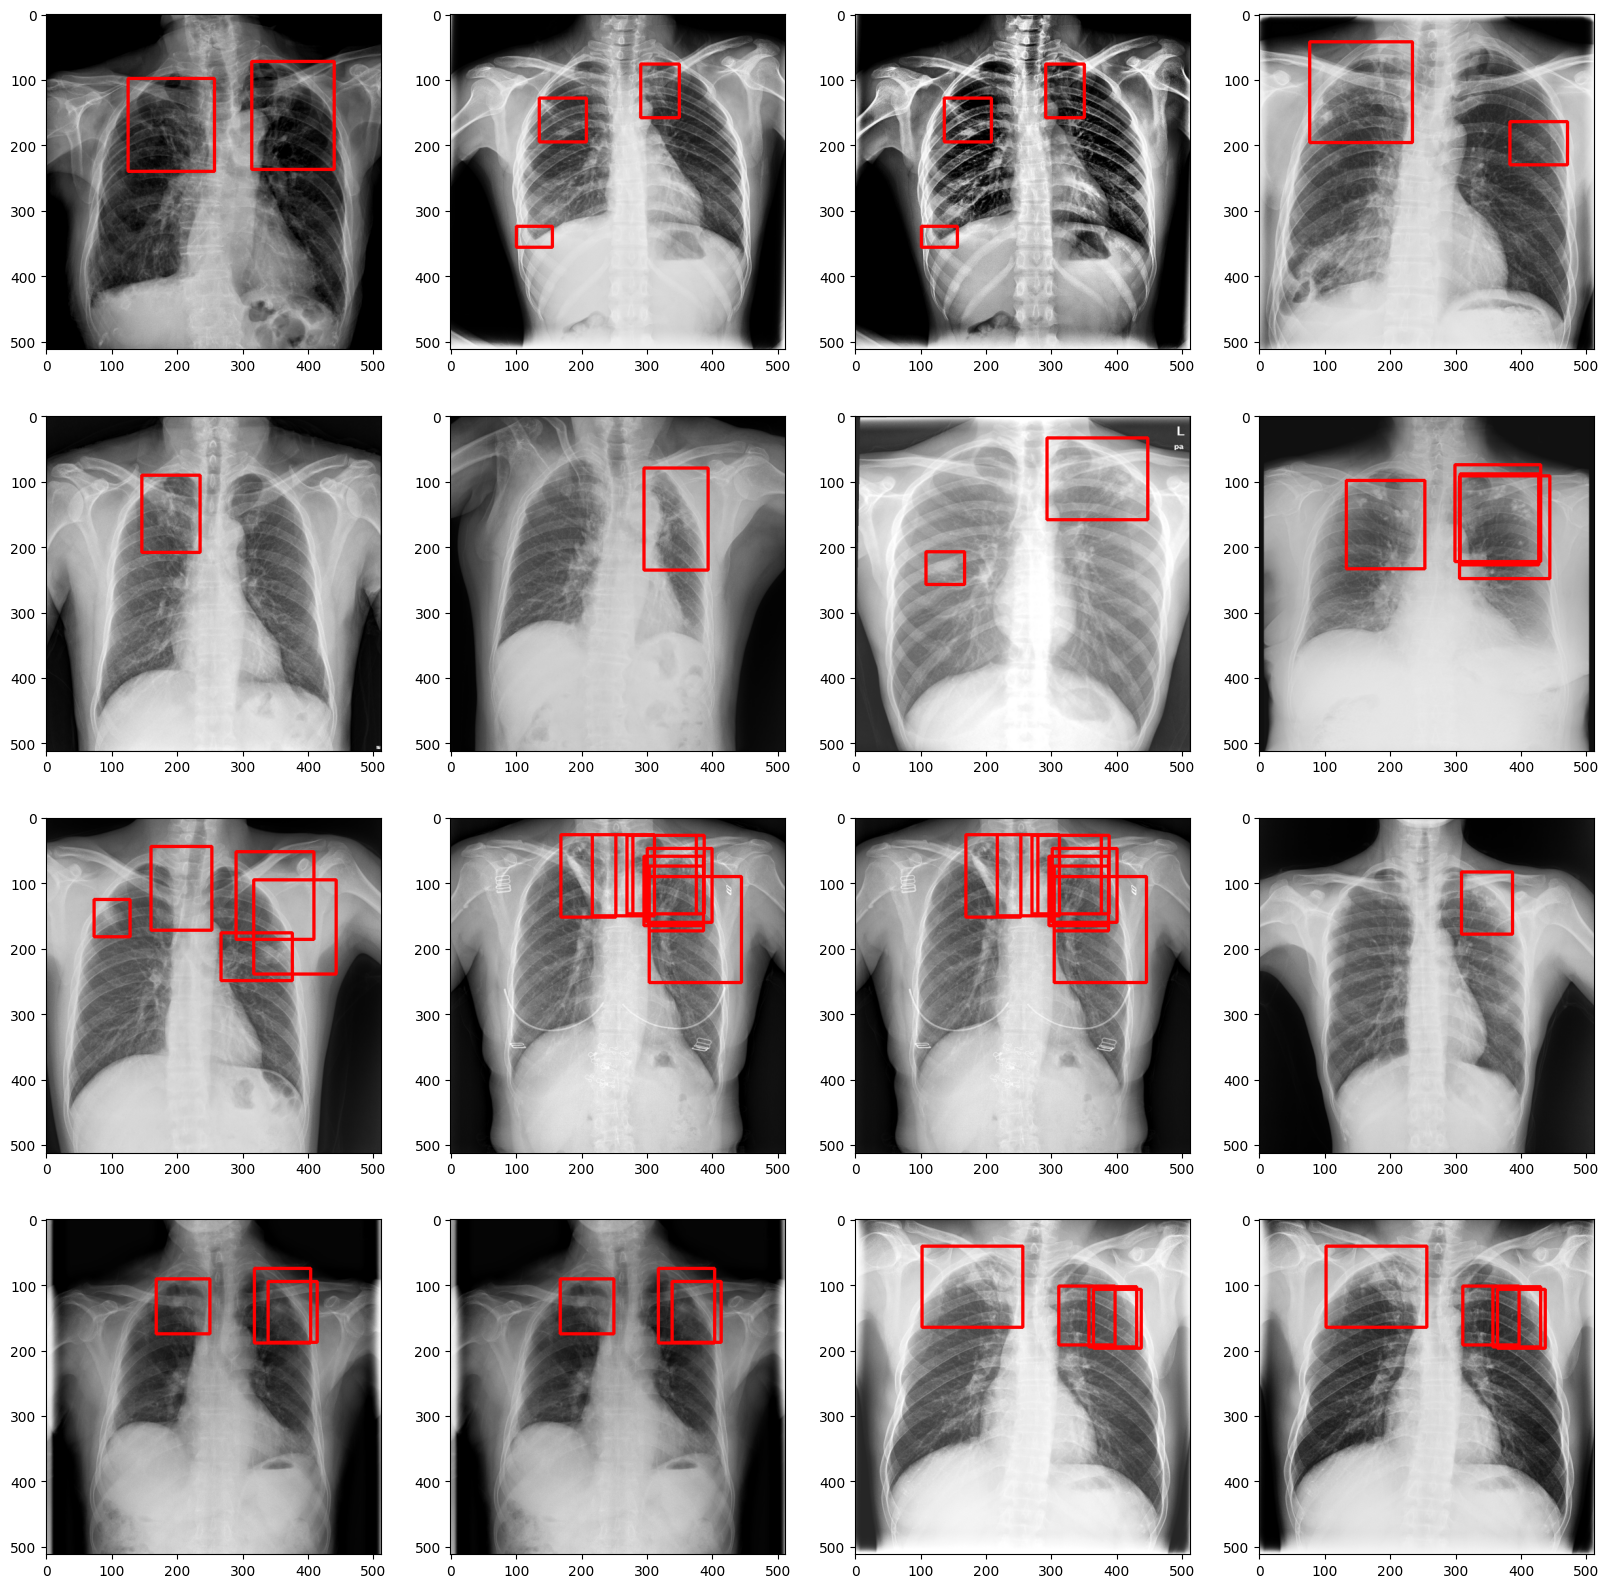

In [45]:
## Lets check some augmentations!

# CHeck validation loader 

## Lets check some augmentations!

# get a fold
df_train = df_folds[df_folds['fold'] != 0]

# create train dataset and data-loader
#train_dataset = get_train_datset(df_train)
#train_data_loader = get_train_data_loader(train_dataset, batch_size = 8)

train_dataset = get_train_datset(df_train)
train_data_loader = get_train_data_loader(train_dataset, batch_size = 16)

device=torch.device('cuda')
images, targets, image_ids = next(iter(train_data_loader))
# Check if a GPU is available, and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = list(image.to(device) for image in images)
#print(images.shape)
#print(targets.shape)
#targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#targets = tuple(torch.tensor(target).to(device) for target in targets)

# Access individual elements of the tuple
#boxes_np = targets[0]['boxes'].numpy().astype(np.float32)
#labels_np = targets[0]['labels'].astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
#boxes = torch.tensor(boxes_np).to(device)
#labels = torch.tensor(labels_np).to(device)
# plot some augmentations!
fig, ax = plt.subplots(figsize=(20, 20),  
                       nrows = 4,
                       ncols = 4)
for i in range (16):    
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
    
    ax[i // 4][i % 4].imshow(sample) 


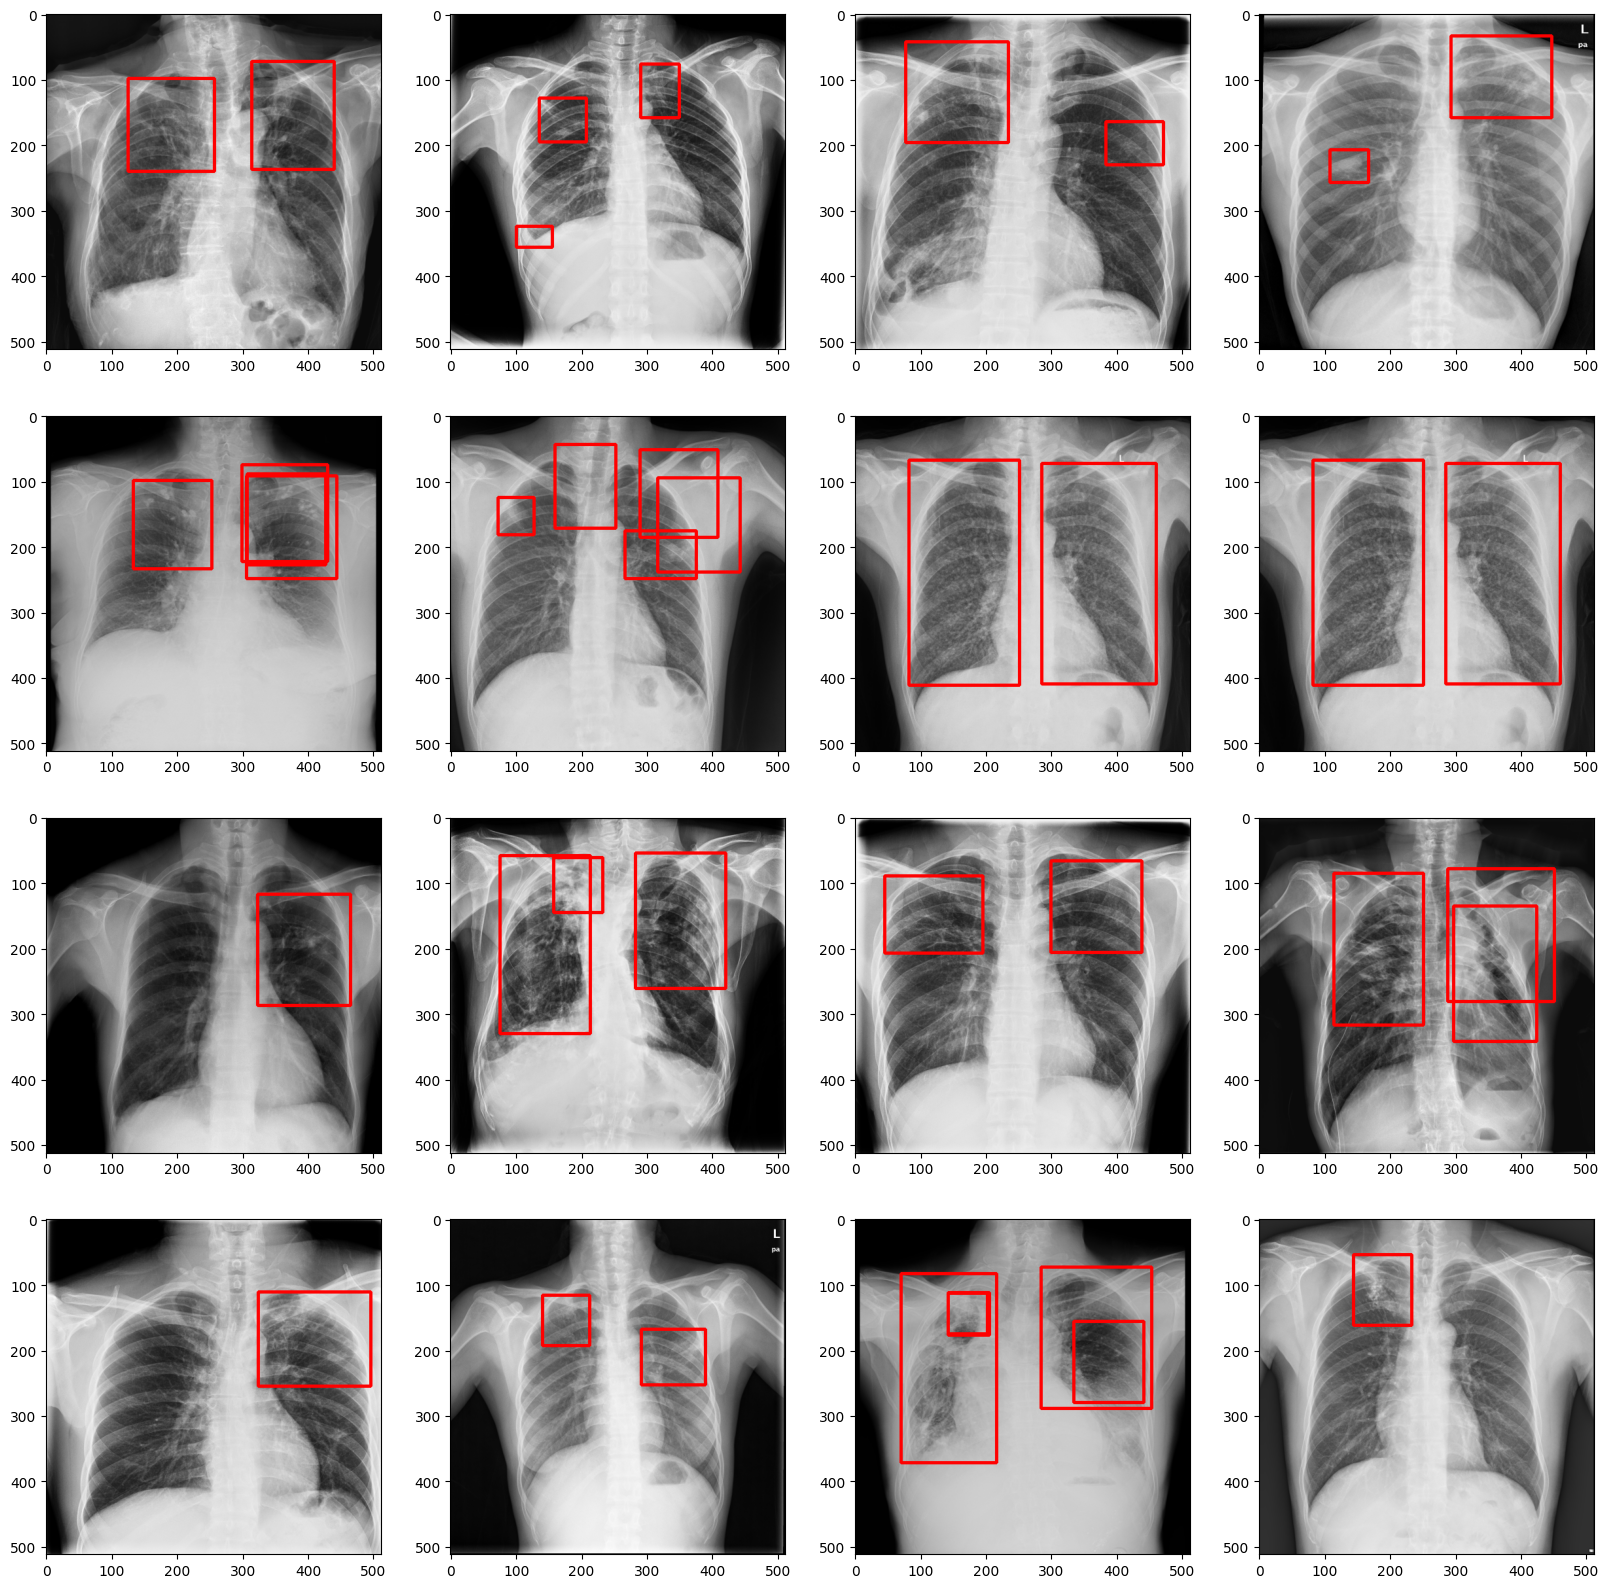

In [46]:
# CHeck validation loader 

## Lets check some augmentations!

# get a fold
df_valid = df_folds[df_folds['fold'] == 0]

# create train dataset and data-loader
#train_dataset = get_train_datset(df_train)
#train_data_loader = get_train_data_loader(train_dataset, batch_size = 8)

validation_dataset = get_validation_datset(df_valid)
validation_data_loader = get_validation_data_loader(validation_dataset, batch_size = 16)

device=torch.device('cuda')
images, targets, image_ids = next(iter(validation_data_loader))
# Check if a GPU is available, and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = list(image.to(device) for image in images)
#print(images.shape)
#print(targets.shape)
#targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#targets = tuple(torch.tensor(target).to(device) for target in targets)

# Access individual elements of the tuple
#boxes_np = targets[0]['boxes'].numpy().astype(np.float32)
#labels_np = targets[0]['labels'].astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
#boxes = torch.tensor(boxes_np).to(device)
#labels = torch.tensor(labels_np).to(device)
# plot some augmentations!
fig, ax = plt.subplots(figsize=(20, 20),  
                       nrows = 4,
                       ncols = 4)
for i in range (16):    
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
    
    ax[i // 4][i % 4].imshow(sample) 

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

# Model 

In [ ]:
""""
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
# Check if COCO or ImageNet information is available in model attributes
if hasattr(model, 'coco_pretrained'):
    print("This model is pretrained on COCO.")
elif hasattr(model, 'imagenet_pretrained'):
    print("This model is pretrained on ImageNet.")
else:
    print("Pretraining dataset information not found.")

In [13]:
import torch
import torchvision.models.detection

num_classes = 3
def get_model():    
    # load pre-trained model incl. head
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier custom head
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
device

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model()
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    # initialize and reset to zero
    def __init__(self):
        self.reset()

    # reset everything to zero    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    # update loss after each batch
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Metrics Function

In [15]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form = form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)



def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), 
                                                     preds, 
                                                     threshold = threshold,
                                                     form = form,
                                                     ious = ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

## Training function

In [16]:
import torch.nn as nn   ## 6 OCT
import torch.nn.functional as F

def train_fn(data_loader,model,optimizer,device,scheduler,epoch):
    # set pytorch to train mode, in which the model will return losses
    
    #clip_value = 0.5
    
    model.train()
    
    #criterion = nn.SmoothL1Loss()      ## 6 OCT
    
    summary_loss = AverageMeter()
    
    #target_boxes = []  # added for SmoothL1
    
    tk0 = tqdm(data_loader, total = len(data_loader))
    
    # actual training steps
    for step, (images, targets, image_ids) in enumerate(tk0):   
        
        # if targets is empty, create empty target tensor        
        if len(targets) < 1:
            target['boxes'] = torch.zeros((0, 4))
        
             
        # prepare data
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Extract bounding box coordinates from the list of dictionaries  # 6OCT
        # Concatenate the list of tensors along a new dimension (dim=0)
        # Concatenate the list of tensors along a new dimension (dim=0)
        #target_boxes = torch.cat(target_boxes, dim=0)    # added for SmoothL1
 
        # calculate loss        
        loss_dict = model(images, targets)        
        losses = sum(loss for loss in loss_dict.values())
                
        # resets gradients of all optimized Tensors before next training step
        optimizer.zero_grad() 
        
        # Apply the Smooth L1 Loss   # 6OCT  # added for SmoothL1
        # Apply the Smooth L1 Loss   # 6OCT
        #smooth_l1_loss = F.smooth_l1_loss(loss_dict['loss_box_reg'], target_boxes, reduction='none')
        #smooth_l1_loss = torch.sum(smooth_l1_loss)  # Sum the loss value
        #total_loss = losses + smooth_l1_loss         
                
        #total_loss.backward()   # added for SmoothL1        
        
        
        # computes derivative of the loss w.r.t. the parameters 
        losses.backward() 
        
        # Gradient clipping   ## 6 OCT
        #nn.utils.clip_grad_norm_(model.parameters(), clip_value)  Precision did not improve
        
        
        # Calculate gradient norm
        #total_norm = 0
        #for param in model.parameters():
            #if param.grad is not None:
               # param_norm = param.grad.data.norm(2)
                #total_norm += param_norm.item() ** 2
        #total_norm = total_norm ** 0.5

        # Print or log gradient norm
        #print(f'Gradient Norm: {total_norm}')

        # Clip gradients if needed
        #if total_norm > clip_value:
            #torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
     
        
        # updates the parameter based on the gradients from previous step
        optimizer.step()
        
        # updates the scheduler if it's defined
        if scheduler is not None:
            scheduler.step()
            
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss = summary_loss.avg)
        
    return summary_loss

# Eval Function

In [17]:
def eval_fn(data_loader, model, device):
    model.eval()
    summary_loss_eval = AverageMeter()
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    validation_image_precisions = []
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            """
            In model.train() mode, model(images)  is returning losses.
            We are using model.eval() mode --> it will return boxes and scores. 
            """
            outputs = model(images)

            for i, image in enumerate(images):
                boxes = outputs[i]['boxes'].data.cpu().numpy()
                scores = outputs[i]['scores'].data.cpu().numpy()
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                preds_sorted_idx = np.argsort(scores)[::-1]
                preds_sorted = boxes[preds_sorted_idx]
                image_precision = calculate_image_precision(preds_sorted,
                                                            gt_boxes,
                                                            thresholds = iou_thresholds,
                                                            form = 'pascal_voc')
                validation_image_precisions.append(image_precision)

    valid_prec = np.mean(validation_image_precisions)
        
    return valid_prec

# GPU Changes only if CUDA ERROR 
https://www.kaggle.com/discussions/getting-started/140636

In [45]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=843d3a2da549e805a1fa5f1375f8b3b6572f52fd59cb804585f62840feaae63e
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
| ID | GPU | MEM  |
-------------------
|  0 |  0% | 100% |


In [46]:
import torch
torch.cuda.empty_cache()

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

In [47]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()    

Initial GPU Usage
| ID | GPU | MEM  |
-------------------
|  0 |  0% | 100% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 92% |  2% |


In [ ]:
def train_loop(files, batch_size, model):
    size = len(files)
    for batch in range(size//batch_size):
        im_paths = files[batch*batch_size : (batch+1)*batch_size]
        X,y = load_batch(im_paths)
        # Compute prediction and loss
        output = model(X, y)
        del X
        del y
        gc.collect()
        torch.cuda.empty_cache()

# Engine

In [ ]:
df_folds

In [64]:
df_folds

class_id  bbox_count  fold
image_id                            
tb0288           1           1     0
tb0288           1           1     1
tb0881           1           1     0
tb0881           1           1     1
tb0881           1           1     2
...            ...         ...   ...
tb0710           2           1     0
tb0549           2           1     4
tb1127           2           1     3
tb0805           2           1     0
tb0518           2           1     3

[1922 rows x 3 columns]

In [65]:
train_data_loader

# RUN function 

In [ ]:
df_folds.fold.value_counts()

In [18]:

import gc

def run(df_folds, fold):
    summary_loss = AverageMeter()
    
    # split data in training and validation set based on the fold
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    print(df_train.count())
    print(df_valid.count())
    
    # get data loaders
    train_dataset = get_train_datset(df_train)
    train_data_loader = get_train_data_loader(train_dataset, batch_size = 8)
    
    validation_dataset = get_validation_datset(df_valid)
    validation_data_loader = get_validation_data_loader(validation_dataset, batch_size = 8)          
     
        
    # get GPU device
    device = torch.device('cuda')
    
    # get model
    model = get_model()
    model = model.to(device)
    
    # get all trainable parameters for the optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    
    # get the configured optimizer
    if Adam:
        optimizer = torch.optim.Adam(params, **Adam_config)
    else:
        optimizer = torch.optim.SGD(params, **SGD_config)
        
    best_precision = 0.01
    for epoch in range(EPOCHS):
        
        # reset loss for each new epoch
        summary_loss.reset()
                                
        train_loss = train_fn(train_data_loader, 
                              model, optimizer, 
                              device, 
                              scheduler = None, 
                              epoch = epoch)
        
        valid_precision = eval_fn(validation_data_loader, 
                                  model,
                                  device)
        
         
        print('|EPOCH {}| TRAIN_LOSS {}| VAL_PRECISION {}|'.format(
            epoch+1,
            train_loss.avg,
            valid_precision))
        
        if valid_precision > best_precision:
            best_precision = valid_precision
            print('Best model found for Epoch {}'.format(epoch+1))
            torch.save(model.state_dict(), f'FRCNN_best_{fold}.pth')
    
    del train_dataset
    del train_data_loader
    del validation_dataset
    del validation_data_loader
    del df_train
    del df_valid
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
import torch
torch.cuda.empty_cache()

import gc
del train_dataset
del train_data_loader
del validation_dataset
del validation_data_loader
del df_train
del df_valid
gc.collect()
torch.cuda.empty_cache()

# RUN ALL FOLDS

In [ ]:
!pwd

In [ ]:
df_folds.fold.value_counts()

In [ ]:
!pwd

In [ ]:
# Fold = 0 

run(df_folds, fold = 0)  ### ADAM = False , Epochs = 30,  SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.0005}

In [ ]:
!jupyter notebook --NotebookApp.iopub_msg_rate_limit=100000

In [ ]:
run(df_folds, fold = 1)  ### SGD , Epochs = 30,  SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.0005}

In [ ]:
run(df_folds, fold = 2)  ### SGD , Epochs = 30,  SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.0005}

In [ ]:
run(df_folds, fold = 3)  ### SGD , Epochs = 30,  SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.0005}

In [ ]:
run(df_folds, fold = 4)  ### SGD , Epochs = 30,  SGD_config = {"lr" : 0.001, "momentum" : 0.9, "weight_decay" : 0.0005}

## Sample Visualization

In [ ]:
df_train

In [ ]:
validation_data_loader

In [ ]:
 df_folds[df_folds['fold'] == 0]

In [ ]:
def view_sample(df_valid,model,device):
    '''
    Code merged from Peter's & KnowNothing's great Kernels
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr
    '''
    
    validation_dataset = get_validation_datset(df_valid)
    validation_data_loader = get_validation_data_loader(validation_dataset, batch_size = 16)
    
    # not needed
    # images, targets, image_ids = next(iter(validation_data_loader))
    # images = list(img.to(device) for img in images)
    # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    #_,h,w = images[0].shape # for de normalizing images
    
    images, targets, image_ids = next(iter(validation_data_loader))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes_gt = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.to(device)
    model.eval()
    cpu_device = torch.device("cpu")
    #model.cuda()

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # paint ground_truth boxes (red)
    for box in boxes_gt:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
        
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
          
    # paint predicted boxes (blue)
    pred_box_count = 0
    for box,p in zip(boxes,scores):        
        if p >0.5:
            pred_box_count += 1
            color = (0,0,220) 
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  color, 2)
    
    
    print(f"Predicted {pred_box_count} BBoxes (blue); Number of GT BBoxes (red) : {len(boxes_gt)}")
    ax.set_axis_off()
    ax.imshow(sample)  

In [ ]:
import torch
torch.cuda.empty_cache()

import gc
del variables
gc.collect()

# Inference

## View Test data

In [ ]:
DIR_TEST = '/kaggle/working/TBX_XML/test_data'
test_images = glob.glob(f"{DIR_TEST}/*")
#test_images
#image = cv2.imread(test_images[2])
#print(image)

In [ ]:
!pwd

In [48]:
### Give the path of the latest model trained  model saved at location 


#model = get_model()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.load_state_dict(torch.load(
    '/kaggle/working/TBX_XML/FRCNN_best_0.pth', map_location=device
))


<All keys matched successfully>

In [ ]:
test_images

In [ ]:
import numpy as np
import cv2
import torch
import glob as glob
import torch
from PIL import Image
from IPython.display import display

#from model import create_model

# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
#model = create_model(num_classes=5).to(device)
model.load_state_dict(torch.load(
    '/kaggle/working/TBX_XML/FRCNN_best_4.pth', map_location=device
))
model.eval()

# directory where all the images are present
DIR_TEST = '/kaggle/working/TBX_XML/test_data'
test_images = glob.glob(f"{DIR_TEST}/*")
#print(f"Test instances: {len(test_images)}")

# classes: 0 index is reserved for background
CLASSES = [
    'background', 'ActiveTuberculosis', 'ObsoletePulmonaryTuberculosis'
]

# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.5

for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    print(DIR_TEST +'/'+ image_name +'.png')
    img_file = DIR_TEST +'/'+ image_name +'.png'
    #image = cv2.imread(test_images[i])
    image = Image.open(img_file)
    orig_image = image.copy()
    # BGR to RGB
    image_np = np.array(orig_image)
    image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)
    print(outputs)
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(image_np,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            cv2.putText(image_np, pred_classes[j], 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                        2, lineType=cv2.LINE_AA)

        #cv2.imshow('Prediction', image_np)
        display(Image.fromarray(image_np))
        #cv2.waitKey(1)
        cv2.imwrite(f"/kaggle/working/test_predictions/{image_name}.png", image_np,)
        #orig_image.save(f"/kaggle/working/test_predictions/{image_name}.png", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')
#cv2.destroyAllWindows()

# Run Inference on VALIDATION DATA

In [ ]:
#!pwd
#!cp -R /kaggle/working/Tutorial-Book-Utils/FRCNN_best_0.pth /kaggle/working/TBX_XML/FRCNN_best_0.pth

In [ ]:
### Give the path of the latest model trained  model saved at location 


model = get_model()


#model.load_state_dict(torch.load(
   #'/kaggle/working/TBX_XML/FRCNN_best_1.pth', map_location=device
#))

In [ ]:
# CAN USE TEST DATA LOADER INSTEAD OF VALIDATION LOADER

In [56]:
def make_prediction(model, img, threshold):
    
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

with torch.no_grad(): 
    # batch size of the test set = 2
    for imgs, annotations, image_ids in test_data_loader:
        imgs = list(img.to(device) for img in imgs)
        model = model.to('cuda')
        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[119.8761,  52.0389, 258.7490, 312.9063],
        [295.8722,  53.1923, 444.0626, 183.5161],
        [308.4446,  66.4468, 431.8054, 181.4244],
        [309.3840,  75.8503, 449.2335, 282.2198],
        [122.9634,  42.5400, 258.4720, 233.6514],
        [299.4825,  61.8835, 457.3806, 291.9541]], device='cuda:0'), 'labels': tensor([1, 1, 2, 2, 2, 1], device='cuda:0'), 'scores': tensor([0.9912, 0.9860, 0.6233, 0.6059, 0.5843, 0.5305], device='cuda:0')}, {'boxes': tensor([[119.8761,  52.0389, 258.7490, 312.9063],
        [295.8722,  53.1923, 444.0626, 183.5161],
        [308.4446,  66.4468, 431.8054, 181.4244],
        [309.3840,  75.8503, 449.2335, 282.2198],
        [122.9634,  42.5400, 258.4720, 233.6514],
        [299.4825,  61.8835, 457.3806, 291.9541]], device='cuda:0'), 'labels': tensor([1, 1, 2, 2, 2, 1], device='cuda:0'), 'scores': tensor([0.9912, 0.9860, 0.6233, 0.6059, 0.5843, 0.5305], device='cuda:0')}, {'boxes': tensor([[150.5316, 119.8117, 256.5350, 220.5603],

In [ ]:
#del pred
#del annot_all
#del preds_adj_all
#del preds_adj

In [57]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot, image_ids in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    
    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


In [58]:
import utils_ObjectDetection as utils
iou_threshold = 0.5
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 0.32360531502151924
AP : tensor([0.6472, 0.0000], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.5
precision : tensor([0.6923, 0.0000])
Recall : tensor([0.8182, 0.0000])
F1 Score : tensor([0.7500, 0.0000])
True Positives : tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 0., 1., 1., 0., 0.])
pred_scores : tensor([0.9912, 0.9860, 0.6233, 0.6059, 0.5843, 0.5305, 0.9912, 0.9860, 0.6233,
        0.6059, 0.5843, 0.5305, 0.9784, 0.8349, 0.8174, 0.6920, 0.5612, 0.5540,
        0.9784, 0.8349, 0.8174, 0.6920, 0.5612, 0.5540, 0.9959, 0.9212, 0.9959,
        0.9212, 0.9993, 0.9409, 0.9306, 0.6417, 0.5361, 0.9983, 0.9898, 0.9983,
        0.9898, 0.9977, 0.9944, 0.6685, 0.9977, 0.9944, 0.6685, 0.9616, 0.6673])
pred_labels : tensor([1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2,
        1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2

In [ ]:
import matplotlib.patches as patches
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0).numpy()
    rects = []
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        
        rects.append(rect)
        #ax.add_patch(rect)
    return img, rects
    #plt.show()

## View Ground truth vs Predicted boxes

In [ ]:
nrows = 10
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot, image_ids in test_data_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        #print(im[sample_i])
        print(annot[sample_i])
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
""""
def visualize_sample(image, target):
        box = target['boxes'][0]
        img = np.array(image)
        label = target['labels']
        cv2.rectangle(
            img, 
            (int(box[0]), int(box[1]), (int(box[2])-int(box[0])), (int(box[3]) -int(box[1]))),
            (0, 255, 0), 2
        )

NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = dataset[i]
        visualize_sample(image, target)

In [ ]:
#duplicate_rows = merged_df_final[merged_df_final.duplicated(subset='image_id', keep=False)].sort_values('image_id')
#duplicate_rows[['image_id', 'true_xmin', 'true_ymin', 'true_width', 'true_height', 'image_num', 'image_num_train', 'image_path', 'class_id']]


## mAP Calculation

In [53]:
!pwd

/kaggle/working/TBX_XML


In [ ]:
%cd ..

In [70]:
%cd /kaggle/working
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

!pip install gdown

!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils
%cd /kaggle/working

/kaggle/working
Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (45/45), 11.62 KiB | 1.94 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Downloading...
From (uriginal): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=0bffe45b-02f6-47bf-ba89-cf49865257ec
To: /kaggle/working/Face Mask Detection.zip
100%|█████████████████████████████████████████| 417M/417M [00:02<00:00, 191MB/s]
Face Mask Detection.zip download complete!
/kaggle/working/Tutorial-Book-Utils
/kaggle/working


In [55]:
import utils_ObjectDetection as utils
iou_threshold = 0.5
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 0.8288443873053559
AP : tensor([0.9294, 0.7283], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.5
precision : tensor([0.9301, 0.8782])
Recall : tensor([0.9336, 0.7301])
F1 Score : tensor([0.9318, 0.7973])
True Positives : tensor([1., 1., 1.,  ..., 1., 1., 1.])
pred_scores : tensor([0.9987, 0.9984, 0.9990,  ..., 0.9995, 0.9970, 0.9775])
pred_labels : tensor([1, 1, 1,  ..., 2, 2, 2])


# Fold = 4

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.5
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.4
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.4) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.6
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.6) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.7
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.7) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.8
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.8) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

# Fold = 3

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.5
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.4
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.4) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.6
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.6) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.7
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.7) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.8
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.8) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

# Fold = 2

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.5
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.4
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.4) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.6
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.6) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.7
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.7) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

# Fold = 1

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.5
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.4
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.4) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.6
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.6) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.7
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.7) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.8
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.8) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

# Fold = 0 

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.5
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.4
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.4) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.6
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.6) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import utils_ObjectDetection as utils
iou_threshold = 0.7
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.7) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

In [ ]:
import torch
import numpy as np

def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        #if outputs[sample_i] is None:
            #continue

        #output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   # 예측 객체 개수
 
        annotations = targets   ## 6 OCT [sample_i]  # actual
        #target_labels = annotations['labels'] if len(annotations) else []
        
        target_labels = annotations[0]['labels'] if len(annotations) else []  # 6 OCT
        
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): # 예측값에 대해서..

                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.2) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.4) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

# **# Ensemble for Folds  ###############################################################

In [18]:
#!mkdir TBX_XML
!cp -R /kaggle/input/frcnn-tbx/* /kaggle/working/TBX_XML

In [19]:
df_test = pd.read_csv('/kaggle/input/frcnn-tbx/df_test.csv')

In [21]:
df_test_index = df_test

df_test_index= df_test_index.set_index('image_id')

In [22]:
df_test_index

width  height  xmin  ymin  xmax  ymax  \
image_id                                          
tb0858     2372    2880  1426   285  2087  1710   
tb0858     2372    2880   516   292  1132  2097   
tb0999     1739    2022   325   481   821   921   
tb0999     1739    2022  1172   523  1645  1128   
tb0915     1801    2022   948   303  1418   781   
tb0915     1801    2022   200   318   694  1026   
tb0294     2997    2977   756   236  1469  1036   
tb0285     2955    2999   487   369  1438  1762   
tb0787     2745    3015   328   482  1054  1451   
tb0787     2745    3015  1448   549  1944  1257   
tb0832     2353    3001  1305   390  1971  1089   
tb0832     2353    3001   381   422  1146  1263   
tb0282     1803    2021   365   376   715   835   

                             class_name  width_ratio  height_ratio  \
image_id                                                             
tb0858               ActiveTuberculosis     0.215852      0.177778   
tb0858               ActiveTuberculosis     0.215852      0.177778   
tb0999               ActiveTuberculosis     0.294422      0.253215   
tb0999               ActiveTuberculosis     0.294422      0.253215   
tb0915               ActiveTuberculosis     0.284287      0.253215   
tb0915               ActiveTuberculosis     0.284287      0.253215   
tb0294               ActiveTuberculosis     0.170838      0.171985   
tb0285               ActiveTuberculosis     0.173266      0.170724   
tb0787               ActiveTuberculosis     0.186521      0.169818   
tb0787               ActiveTuberculosis     0.186521      0.169818   
tb0832               ActiveTuberculosis     0.217595      0.170610   
tb0832               ActiveTuberculosis     0.217595      0.170610   
tb0282    ObsoletePulmonaryTuberculosis     0.283971      0.253340   

           true_xmin   true_ymin  true_width  true_height  \
image_id                                                    
tb0858    307.804384   50.666667  142.677909   253.333333   
tb0858    111.379427   51.911111  132.964587   320.888889   
tb0999     95.687177  121.796241  146.033353   111.414441   
tb0999    345.062680  132.431256  139.261645   153.194857   
tb0915    269.503609   76.724036  133.614659   121.036597   
tb0915     56.857301   80.522255  140.437535   179.275964   
tb0294    129.153153   40.588512  121.807140   137.588176   
tb0285     84.380372   62.996999  164.775635   237.817939   
tb0787     61.178871   81.852073  135.414208   164.553234   
tb0787    270.082332   93.229851   92.514390   120.230846   
tb0832    283.960901   66.537821  144.917977   119.256248   
tb0832     82.903527   71.997334  166.459839   143.482839   
tb0282    103.649473   95.255814   99.389906   116.283028   

                                          image_path  class_id  Unnamed: 16  
image_id                                                                     
tb0858    /kaggle/working/TBX_XML/orig_images/tb0858         1          NaN  
tb0858    /kaggle/working/TBX_XML/orig_images/tb0858         1          NaN  
tb0999    /kaggle/working/TBX_XML/orig_images/tb0999         1          NaN  
tb0999    /kaggle/working/TBX_XML/orig_images/tb0999         1          NaN  
tb0915    /kaggle/working/TBX_XML/orig_images/tb0915         1          NaN  
tb0915    /kaggle/working/TBX_XML/orig_images/tb0915         1          NaN  
tb0294    /kaggle/working/TBX_XML/orig_images/tb0294         1          NaN  
tb0285    /kaggle/working/TBX_XML/orig_images/tb0285         1          NaN  
tb0787    /kaggle/working/TBX_XML/orig_images/tb0787         1          NaN  
tb0787    /kaggle/working/TBX_XML/orig_images/tb0787         1          NaN  
tb0832    /kaggle/working/TBX_XML/orig_images/tb0832         1          NaN  
tb0832    /kaggle/working/TBX_XML/orig_images/tb0832         1          NaN  
tb0282    /kaggle/working/TBX_XML/orig_images/tb0282         2          NaN

In [23]:
df_test.count()

image_id        13
width           13
height          13
xmin            13
ymin            13
xmax            13
ymax            13
class_name      13
width_ratio     13
height_ratio    13
true_xmin       13
true_ymin       13
true_width      13
true_height     13
image_path      13
class_id        13
Unnamed: 16      0
dtype: int64

In [24]:
merged_df_final = pd.read_csv(r'/kaggle/input/frcnn-tbx/merged_df_final.csv')

df_folds = pd.read_csv('/kaggle/input/frcnn-tbx/df_folds_backup.csv')

merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   true_xmin        1922 non-null   float64
 1   true_ymin        1922 non-null   float64
 2   true_width       1922 non-null   float64
 3   true_height      1922 non-null   float64
 4   image_num        1922 non-null   int64  
 5   image_num_train  1922 non-null   int64  
 6   image_id         1922 non-null   object 
 7   image_path       1922 non-null   object 
 8   class_id         1922 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 135.3+ KB


In [25]:
merged_df_final.count()

true_xmin          1922
true_ymin          1922
true_width         1922
true_height        1922
image_num          1922
image_num_train    1922
image_id           1922
image_path         1922
class_id           1922
dtype: int64

In [26]:
df_folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    1922 non-null   object
 1   class_id    1922 non-null   int64 
 2   bbox_count  1922 non-null   int64 
 3   fold        1922 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 60.2+ KB


In [27]:
df_folds = df_folds.set_index('image_id')

In [43]:
""""
import glob
DATA_ROOT_PATH = '/kaggle/working/TBX_XML/test_data'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        #print(image_id)
        #image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.png', cv2.IMREAD_COLOR)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = Image.open(f'{DATA_ROOT_PATH}/{image_id}.png').convert("RGB")
        #image /= 255.0
        img_np = np.array(image)
        if self.transforms:
            sample = {'image': img_np}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

def get_wbf_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob.glob(f'{DATA_ROOT_PATH}/*.png')]),
    transforms=get_wbf_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    drop_last=False,
    collate_fn=collate_fn
)

In [44]:
import torch
torch.cuda.empty_cache()

In [49]:
del net

NameError: name 'net' is not defined

In [22]:
### Give the path of the latest model trained  model saved at location 


#model = get_model()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.load_state_dict(torch.load(
    '/kaggle/input/frcnn-tbx/FRCNN_best_0.pth', map_location=device
))


<All keys matched successfully>

In [46]:
del net
gc.collect()

NameError: name 'net' is not defined

In [88]:
import gc
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

!export CUDA_LAUNCH_BLOCKING=1

def load_net(checkpoint_path):
    net = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
    num_classes = 3  # 2 + background
    # get number of input features for the classifier
    in_features = net.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint)
    net = net.cuda()
    net.eval()

    del checkpoint
    gc.collect()
    return net

#model1= load_net('/kaggle/input/frcnn-tbx/FRCNN_best_0.pth')
models = [
    load_net('/kaggle/input/frcnn-tbx/FRCNN_best_0.pth'),
    load_net('/kaggle/input/frcnn-tbx/FRCNN_best_1.pth'),
    load_net('/kaggle/input/frcnn-tbx/FRCNN_best_2.pth'),
    load_net('/kaggle/input/frcnn-tbx/FRCNN_best_3.pth'),
    load_net('/kaggle/input/frcnn-tbx/FRCNN_best_4.pth'),
]

In [30]:
!pip install ensemble-boxes

In [160]:
def make_prediction(model, img, threshold):
    
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

with torch.no_grad(): 
    # batch size of the test set = 2
    for imgs, annotations, image_ids in test_data_loader:
        imgs = list(img.to(device) for img in imgs)
        model = model.to('cuda')
        pred = make_prediction(model, imgs, 0.5)
        #print(pred)
        break

[{'boxes': tensor([[152.1922, 113.3453, 287.3328, 398.9664],
        [ 73.0531, 121.6765, 329.0096, 468.7920],
        [342.9543, 169.1815, 495.9272, 396.8106],
        [111.0571, 175.6244, 255.2112, 490.4829],
        [ 19.5047, 343.8604, 117.4099, 497.1997],
        [391.2549, 236.9415, 456.8782, 401.3094],
        [  0.7246, 209.0482, 174.6333, 496.4360],
        [  0.0000, 168.4429, 512.0000, 490.9740],
        [507.3297, 500.7021, 512.0000, 511.5059],
        [  0.0000, 256.3340, 333.6867, 494.1373],
        [ 85.9177, 432.5502, 512.0000, 500.9837],
        [194.7855, 143.0661, 242.7410, 324.7354],
        [327.3887, 181.7310, 384.1366, 347.5812],
        [318.2388, 185.5313, 463.6802, 483.1317],
        [371.3308, 349.2137, 479.3339, 405.2675],
        [508.1068, 191.9911, 512.0000, 235.4840],
        [267.2953, 240.8961, 512.0000, 404.6655],
        [187.7648, 131.9265, 512.0000, 417.1901],
        [508.1984, 166.8010, 511.9701, 201.4933]], device='cuda:0'), 'labels': tensor([1,

In [196]:
from ensemble_boxes import *

device = torch.device('cuda')

def make_ensemble_predictions(images, threshold):
    images = list(image.to(device) for image in images)    
    #result = []
    k = 0
    ensemble_preds = []
    for net in models:
        k = k+1
        preds = net(images)
        #result.append(outputs)   # Commented
        #print( f'model_{k}', preds)
        #print("length of preds:",len(preds))
        filtered_preds = []
        for id in range(len(preds)) :
            idx_list = []
            for idx, score in enumerate(preds[id]['scores']) :
                if score > threshold: 
                    idx_list.append(idx)
            #filtered_pred ={
                #'boxes' : preds[id]['boxes'][idx_list],
                #'labels' : preds[id]['labels'][idx_list],
                #'scores' : preds[id]['scores'][idx_list]
                #}
            #filtered_preds.append(filtered_pred)
            #print("Filtered pred for an image: ",filtered_preds)
            preds[id]['boxes'] = preds[id]['boxes'][idx_list]
            preds[id]['labels'] = preds[id]['labels'][idx_list]
            preds[id]['scores'] = preds[id]['scores'][idx_list]
            ensemble_preds.extend(preds)
        #ensemble_preds.append(filtered_preds) 
        
        #result.append(preds) 
    #print("Combined Model Result for an image: ", ensemble_preds)
        
    return ensemble_preds

def run_wbf(predictions, image_index, image_size=512, iou_thr=0, skip_box_thr=0.8, weights=None):
    boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [236]:
gc.collect()

0

In [108]:
del labels 
del targets_all
del targets_all
del labels
del sample
del test_data_loader
#del predictions
del boxes
del scores
del labels 
gc.collect()
del data_loader

NameError: name 'labels' is not defined

In [ ]:
""""
import matplotlib.pyplot as plt
labels = []
targets_all = []
for j, (images, targets,  image_ids) in enumerate(test_data_loader):
    print(image_ids)
    #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    #labels.extend([t['labels'] for t in targets])
    # Extend targets_all with the targets from the current batch
    #targets_all.extend(targets)
    #print(targets)
    if j > 0:
        break
predictions = make_ensemble_predictions(images,0.5)
#print(predictions)
#for i in range(len(images)):
i = 1

sample = images[0].permute(1,2,0).cpu().numpy()
boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample);

In [101]:
#for fold in range(num_folds):
valid_fold = df_folds[df_folds['fold'] == 2]
new_valid_dataset = get_validation_datset(valid_fold)
    #fold_datasets.append(valid_dataset)
# Combine datasets from different folds into a single dataset
#combined_valid_dataset = CombinedValidationDataset(fold_datasets)
new_valid_loader = get_validation_data_loader(new_valid_dataset, batch_size = 2)

In [142]:
#predictions

In [238]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot, image_ids in tqdm(test_data_loader, position = 0, leave = True):
    #print(image_ids)
    im = list(img.to(device) for img in im)
    
    for t in annot:
        labels += t['labels']
    #print(annot)
    with torch.no_grad():
        preds_adj = make_ensemble_predictions( im,0.8)
        #print("Returned Preds: ", preds_adj)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)
#print("All Predictions: ", preds_adj_all)
#print("All Annotations:", annot_all)

100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


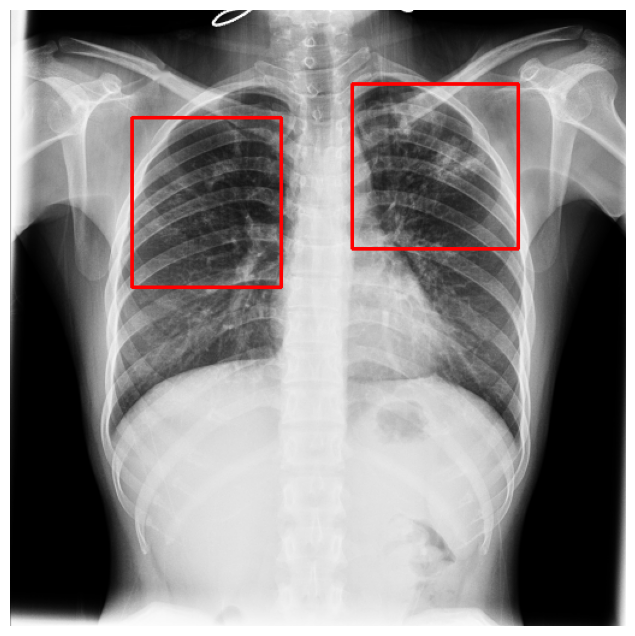

In [229]:
for j, (images, targets,  image_ids) in enumerate(new_valid_loader):
    if j > 0:

        i = 1
#print(images[0])
sample = images[0].permute(1,2,0).cpu().numpy()
boxes, scores, labels = run_wbf(preds_adj_all, image_index=0)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample);

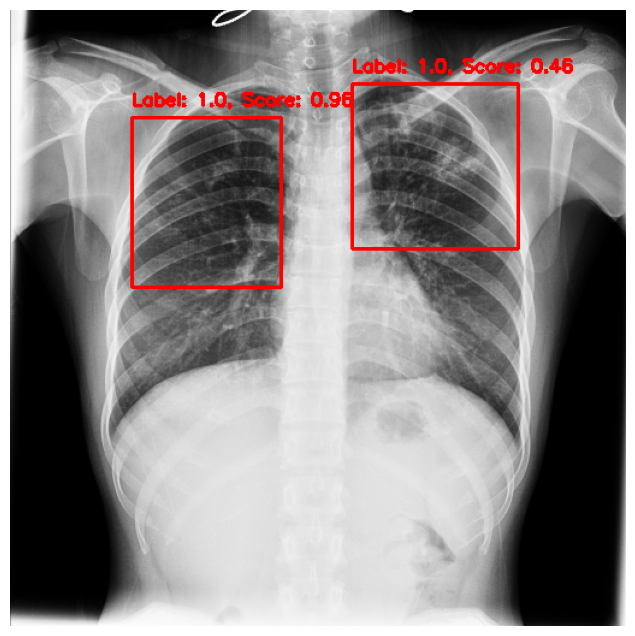

In [233]:
import cv2

# Load your image and get boxes, scores, and labels
sample = images[0].permute(1, 2, 0).cpu().numpy()
boxes, scores, labels = run_wbf(preds_adj_all, image_index=0)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# Iterate over boxes, scores, and labels
for box, score, label in zip(boxes, scores, labels):
    if label == 2:
        box_color = (0, 255, 0)  # Green for label 2
        text_color = (0, 255, 0)
    else:
        box_color = (220, 0, 0)  # Red for other labels
        text_color = (220, 0, 0)
    
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), box_color, 2)
    
    # Add label and score to the image with the specified text color
    label_text = f"Label: {label}, Score: {score:.2f}"
    cv2.putText(sample, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)

ax.set_axis_off()
ax.imshow(sample);


In [94]:
#preds_adj_all

In [65]:
""""
# Initialize labels and targets_all lists
labels = []
targets_all = []

for j, (images, targets, image_ids) in enumerate(test_data_loader):
    # Extract labels from targets using a list comprehension
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    labels.extend([t['labels'] for t in targets])
    # Extend targets_all with the targets from the current batch
    targets_all.extend(targets)


## mAP - ALL Models Combined

In [245]:
import utils_ObjectDetection as utils
iou_threshold = 0.5
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 1.3292191929222272
AP : tensor([2.4247, 0.2338], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.5
precision : tensor([0.7738, 0.0364])
Recall : tensor([2.9545, 2.0000])
F1 Score : tensor([1.2264, 0.0714])
True Positives : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.814

In [249]:
import utils_ObjectDetection as utils
iou_threshold = 0.4
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.4) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 2.047077959911391
AP : tensor([3.6786, 0.4156], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.4
precision : tensor([0.9643, 0.0545])
Recall : tensor([3.6818, 3.0000])
F1 Score : tensor([1.5283, 0.1071])
True Positives : tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.8145

In [246]:
import utils_ObjectDetection as utils
iou_threshold = 0.6
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.6) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 0.8625302764052605
AP : tensor([1.7251, 0.0000], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.6
precision : tensor([0.6310, 0.0000])
Recall : tensor([2.4091, 0.0000])
F1 Score : tensor([1., 0.])
True Positives : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.8145, 0.806

In [247]:
import utils_ObjectDetection as utils
iou_threshold = 0.7
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.7) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 0.6973174708938532
AP : tensor([1.3946, 0.0000], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.7
precision : tensor([0.5357, 0.0000])
Recall : tensor([2.0455, 0.0000])
F1 Score : tensor([0.8491, 0.0000])
True Positives : tensor([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.814

In [248]:
import utils_ObjectDetection as utils
iou_threshold = 0.8
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.8) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 0.11459666860698903
AP : tensor([0.2292, 0.0000], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.8
precision : tensor([0.2143, 0.0000])
Recall : tensor([0.8182, 0.0000])
F1 Score : tensor([0.3396, 0.0000])
True Positives : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.81

In [257]:
import utils_ObjectDetection as utils
iou_threshold = 0.75
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.75) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 0.4283577545293391
AP : tensor([0.8567, 0.0000], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.75
precision : tensor([0.4167, 0.0000])
Recall : tensor([1.5909, 0.0000])
F1 Score : tensor([0.6604, 0.0000])
True Positives : tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
        0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.81

In [258]:
import utils_ObjectDetection as utils
iou_threshold = 0.65
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.65) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 0.8209102562150785
AP : tensor([1.6418, 0.0000], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.65
precision : tensor([0.6071, 0.0000])
Recall : tensor([2.3182, 0.0000])
F1 Score : tensor([0.9623, 0.0000])
True Positives : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.81

In [260]:
import utils_ObjectDetection as utils
iou_threshold = 0.55
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.55) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 1.0301839628768739
AP : tensor([1.8266, 0.2338], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.55
precision : tensor([0.6548, 0.0364])
Recall : tensor([2.5000, 2.0000])
F1 Score : tensor([1.0377, 0.0714])
True Positives : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.81

In [261]:
import utils_ObjectDetection as utils
iou_threshold = 0.45
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.45) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 1.9561688662929981
AP : tensor([3.6786, 0.2338], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.45
precision : tensor([0.9643, 0.0364])
Recall : tensor([3.6818, 2.0000])
F1 Score : tensor([1.5283, 0.0714])
True Positives : tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.81

In [266]:
import utils_ObjectDetection as utils
iou_threshold = 0.77
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.77) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 0.27868610574781005
AP : tensor([0.5574, 0.0000], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.77
precision : tensor([0.3333, 0.0000])
Recall : tensor([1.2727, 0.0000])
F1 Score : tensor([0.5283, 0.0000])
True Positives : tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
        0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.8

In [269]:
import utils_ObjectDetection as utils
iou_threshold = 0.45
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i],
                                                 iou_threshold=0.45) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'AP : {ap_class}')
print(f'IoU Threshold : {iou_threshold}')
print(f'precision : {precision}')
print(f'Recall : {recall}')
print(f'F1 Score : {f1}')

print(f'True Positives : {true_positives}')
print(f'pred_scores : {pred_scores}')
print(f'pred_labels : {pred_labels}')

mAP : 1.9561688662929981
AP : tensor([3.6786, 0.2338], dtype=torch.float64)
AP : tensor([1, 2])
IoU Threshold : 0.45
precision : tensor([0.9643, 0.0364])
Recall : tensor([3.6818, 2.0000])
F1 Score : tensor([1.5283, 0.0714])
True Positives : tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.])
pred_scores : tensor([0.9911, 0.9852, 0.9920, 0.9629, 0.8464, 0.9924, 0.9856, 0.9687, 0.8920,
        0.8534, 0.9967, 0.8038, 0.9864, 0.81

In [201]:
#FINAL WORKING ---------------

sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics_combined(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.4) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

TypeError: tuple indices must be integers or slices, not str

In [ ]:

def make_prediction(model, img, image_id, threshold):
    #model.load_state_dict(torch.load(
    #'/kaggle/working/TBX_XML/FRCNN_best_5_Epochs_0.pth', map_location=device
    #))
    
    print(image_id)
    model = model.to('cuda')
    model.eval()
    #img = img.to('cuda')
    preds = model(img)
    
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]
        # Assign the same image_ids to all predictions in the list
    for pred in preds:
        pred['image_id'] = image_id

    return preds

# Earlier Ensemble code

In [ ]:
class CombinedValidationDataset(torch.utils.data.Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.cumulative_lengths = [0]  # Store the cumulative lengths of datasets

        for dataset in self.datasets:
            self.cumulative_lengths.append(self.cumulative_lengths[-1] + len(dataset))

    def __getitem__(self, index):
        # Find the corresponding dataset for the given index
        fold_index = bisect.bisect_right(self.cumulative_lengths, index) - 1
        if fold_index == -1:
            sample_index_within_fold = index
        else:
            sample_index_within_fold = index - self.cumulative_lengths[fold_index]

        return self.datasets[fold_index][sample_index_within_fold]

    def __len__(self):
        return self.cumulative_lengths[-1]
    
    

def get_combined_valid_data_loader(combined_valid_dataset, batch_size = 4):
    return DataLoader(
    combined_valid_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
    ) 


In [ ]:

# Load the saved model weights for all folds
model_instances = []
DIR_MODEL = '/kaggle/working/TBX_XML'
all_models = glob.glob(f"{DIR_MODEL}/FRCNN*")
num_folds = 5

#print(all_models)
for model_fold in range(len(all_models)): 
    #print(all_models[model_fold].split('/')[-1])
    model_name = all_models[model_fold].split('/')[-1]
    model_instances.append(model_name)
    
    
# Create a list to hold datasets for different folds
fold_datasets = []

for fold in range(num_folds):
    valid_fold = df_folds[df_folds['fold'] == fold]
    valid_dataset = get_validation_datset(valid_fold)
    fold_datasets.append(valid_dataset)
# Combine datasets from different folds into a single dataset
combined_valid_dataset = CombinedValidationDataset(fold_datasets)
combined_valid_loader = get_combined_valid_data_loader(combined_valid_dataset, batch_size = 16)

In [ ]:
import bisect
import torch
import numpy as np

combined_annot = [] 
 
    
with torch.no_grad(): 
    # batch size of the test set = 2
    predictions = []  # Initialize a list to store predictions for all images    
    for model_run in model_instances:
        model_path = os.path.join('/kaggle/working/TBX_XML/', model_run)
        print(model_path)
        model = get_model() 
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        for batch in combined_valid_loader:
            imgs, annot, image_ids_batch  = batch  # Unpack the batch into imgs, annot, and image_ids
            
                       
            #imgs = list(img.to(device) for img in imgs)
            for i in range(len(imgs)):
                img = [imgs[i].to(device)]
                annot_batch = annot[i]  # Get the annotations for this image
                img_ids = image_ids_batch[i]  # Get the image IDs for this image

                for img_id in img_ids:
                    # Append image_id and labels for each annotation in the batch
                    image_ids.extend([img_id] * len(annot_batch))
                    labels.extend(annot_batch[0]['labels'].cpu().numpy().tolist())


                 # Modify annotations to add image_id for each annotation in the batch
                for t in annot[i]:
                    t['image_id'] = img_id

                # Extend combined_annot with annotations from the current batch
                combined_annot.extend(annot[i])
                print(combined_annot)

                #print(imgs)
                # Make predictions for the current model and fold
                pred = make_prediction(model, img,img_id, 0.5) 

                #pred['image_id'] = image_ids
                #print(pred)
                # Append predictions to the list
                predictions.extend(pred)
            #break  
        # Check if predictions is empty
        if not predictions:
            print("No predictions to combine.")
        else:
            # Print the first prediction to understand its structure
            print("Sample prediction:")
            print(predictions[0])
            # Combine predictions from all folds for this model
            final_predictions = combine_pred(predictions)
            print(final_predictions)     

In [ ]:
def combine_pred(predictions):
    combined_predictions = {}

    for pred in predictions:
        image_id = pred['image_id'].item()  # Extract the image_id as an integer

        if image_id not in combined_predictions:
            combined_predictions[image_id] = {
                'boxes': [],
                'labels': [],
                'scores': []
            }

        combined_predictions[image_id]['boxes'].append(pred['boxes'])
        combined_predictions[image_id]['labels'].append(pred['labels'])
        combined_predictions[image_id]['scores'].append(pred['scores'])

    # Convert the lists to tensors for each image_id
    for image_id, prediction_data in combined_predictions.items():
        combined_predictions[image_id]['boxes'] = torch.cat(prediction_data['boxes'])
        combined_predictions[image_id]['labels'] = torch.cat(prediction_data['labels'])
        combined_predictions[image_id]['scores'] = torch.cat(prediction_data['scores'])

    return combined_predictions


In [ ]:
def combine_predictions_byimage(predictions):
    combined_predictions = []

    for i in range(len(predictions[0])):  # Loop through each image in the batch
        image_predictions = [preds[i] for preds in predictions]  # Get predictions for the current image from all models
        
        # Concatenate predictions for this image from different models
        combined_prediction = {
            'boxes': torch.cat([pred['boxes'] for pred in image_predictions]),
            'labels': torch.cat([pred['labels'] for pred in image_predictions]),
            'scores': torch.cat([pred['scores'] for pred in image_predictions]),
        }

        combined_predictions.append(combined_prediction)

    return combined_predictions

In [ ]:
# Initialize an empty list to store combined predictions
combined_predictions = []
combined_annot = []  # Initialize an empty list to store combined annotations

for im, annot, image_ids in tqdm(combined_valid_loader, position=0, leave=True):
    im = list(img.to(device) for img in im)
    
    for t in annot:
        labels += t['labels']
    
    # Extend combined_annot with annotations from the current batch
    combined_annot.extend(annot)

    with torch.no_grad():
        preds_adj = []  # Initialize an empty list for predictions
        for model_run in model_instances:
            model_path = os.path.join('/kaggle/working/TBX_XML/', model_run)
            model = get_model() 
            model.load_state_dict(torch.load(model_path))
            model.to(device)
            
            # Make predictions for the current model and fold
            model_preds = make_prediction(model, im, 0.15)
            
            # Append the predictions to the list
            preds_adj.extend(model_preds)
        
        # Convert the predictions to CPU and store them in combined_predictions
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        
        # Ensure consistent keys and structure in combined_predictions
        for pred in preds_adj:
            assert 'boxes' in pred, "Key 'boxes' missing in predictions."
            assert 'labels' in pred, "Key 'labels' missing in predictions."
            # Add more assertions for other keys as needed
            
        combined_predictions.append(preds_adj)

# Now you have the combined_predictions list containing predictions from all folds

# Ensure consistent keys and structure in combined_annot
for annot in combined_annot:
    assert 'boxes' in annot, "Key 'boxes' missing in annotations."
    assert 'labels' in annot, "Key 'labels' missing in annotations."
    # Add more assertions for other keys as needed

# Print all ground truth annotations
print("Ground Truth Annotations:")
for annotations in combined_annot:
    print(annotations)

# Print all combined predictions
print("Combined Predictions:")
for predictions in combined_predictions:
    print(predictions)

In [ ]:
del fold_datasets
del get_combined_valid_data_loader
del combined_valid_dataset
del combined_valid_loader

# Combined Predictions and Annotations

In [ ]:
model_instances

In [ ]:
import matplotlib.patches as patches
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0).numpy()
    rects = []
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        
        rects.append(rect)
        #ax.add_patch(rect)
    return img, rects
    #plt.show()

In [ ]:
nrows = 30
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot , image_ids  in combined_valid_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        #print(im[sample_i])
        print(annot[sample_i])
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()
plt.close()



def visualize_sample(image, target):
        box = target['boxes'][0]
        img = np.array(image)
        label = target['labels']
        cv2.rectangle(
            img, 
            (int(box[0]), int(box[1]), (int(box[2])-int(box[0])), (int(box[3]) -int(box[1]))),
            (0, 255, 0), 2
        )

NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = dataset[i]
        visualize_sample(image, target)

# Chat option 1

In [ ]:
del model_preds 

In [ ]:
del combined_annot
del model_instances
del pred

In [ ]:
del final_combined_predictions
del combined_predictions
del all_model_predictions
del combined_valid_loader
del combined_valid_dataset
del predictions


In [ ]:
import os
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import bisect
import glob
from tqdm import tqdm

# Define your model and data loading functions here
# ...
final_combined_predictions=[]
# Modify the combine_predictions function
def combine_predictions(predictions):
    combined_predictions = {
        'boxes': torch.cat([pred['boxes'] for pred in predictions]),
        'labels': torch.cat([pred['labels'] for pred in predictions]),
        'scores': torch.cat([pred['scores'] for pred in predictions]),
    }

    return [combined_predictions]

# Rest of your code
# ...

# Inside the main loop
all_model_predictions = []

for model_run in model_instances:
    model_path = os.path.join('/kaggle/working/TBX_XML/', model_run)
    model = get_model() 
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    
    for imgs, annotations,image_ids  in combined_valid_loader:
        imgs = list(img.to(device) for img in imgs)

        # Make predictions for the current model and fold
        model_preds = make_prediction(model, im, 0.5)

        # Append the predictions to the list
        all_model_predictions.extend(model_preds)

# Combine predictions from all models
final_combined_predictions = combine_predictions(all_model_predictions)

# Evaluate Combined Predictions (modify as needed)
# Calculate mAP or any other evaluation metric
# ...

# Optionally, apply post-processing steps to final_combined_predictions
# ...

# Optionally, visualize or save the final_combined_predictions
# ...



# Chat Option 2

In [ ]:
model_instances

In [ ]:
# Inside the main loop
all_model_predictions = []

for model_run in model_instances:
    model_path = os.path.join('/kaggle/working/TBX_XML/', model_run)
    model = get_model() 
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    # Make predictions for the current model and fold
    model_preds = make_prediction(model, im, 0.5)

    # Append the predictions to the list
    all_model_predictions.append(model_preds)

# Combine predictions from all models for each image
combined_predictions = []
for i in range(len(im)):  # Loop through each image in the batch
    image_predictions = [model_preds[i] for model_preds in all_model_predictions]  # Get predictions for the current image from all models
    
    # Choose the prediction with the highest score for each class
    selected_predictions = {}
    for pred in image_predictions:
        for label in pred['labels']:
            if label not in selected_predictions or pred['scores'][pred['labels'] == label][0] > selected_predictions[label]['scores'][0]:
                selected_predictions[label] = {
                    'boxes': pred['boxes'][pred['labels'] == label],
                    'labels': pred['labels'][pred['labels'] == label],
                    'scores': pred['scores'][pred['labels'] == label]
                }

    combined_predictions.extend(list(selected_predictions.values()))

# Evaluate Combined Predictions (modify as needed)
# Calculate mAP or any other evaluation metric
# ...

# Optionally, apply post-processing steps to combined_predictions
# ...

# Optionally, visualize or save the combined_predictions
# ...


In [ ]:
sample_metrics = []
for batch_i in range(len(final_combined_predictions)):
    sample_metrics += get_batch_statistics_combined(combined_predictions[batch_i], combined_annot[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

## Ensemble Metrics

In [ ]:
!pwd 

In [57]:
%cd /kaggle/working/TBX_XML

!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

!pip install gdown

!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils
%cd /kaggle/working/TBX_XML


/kaggle/working/TBX_XML
Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (45/45), 11.62 KiB | 150.00 KiB/s, done.
Resolving deltas: 100% (18/18), done.
Downloading...
From (uriginal): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=014926b9-263b-43cb-a73c-4282e6c7809b
To: /kaggle/working/TBX_XML/Face Mask Detection.zip
100%|████████████████████████████████████████| 417M/417M [00:08<00:00, 51.5MB/s]
Face Mask Detection.zip download complete!
/kaggle/working/TBX_XML/Tutorial-Book-Utils
/kaggle/working/TBX_XML


In [58]:
import utils_ObjectDetection as utils

In [ ]:
%cd ..

In [ ]:
predictions[0]
#annot_all[0]

In [ ]:
predictions[0]

In [209]:
#### FINAL WORKING 

import torch
import numpy as np

def get_batch_statistics_combined(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']
        #print("Output:", output)
        true_positives = torch.zeros(output['boxes'].shape[0])   # 예측 객체 개수

        #print("targets:", targets)
        #print("sample_i:", sample_i)

        annotations = targets[0]   #[sample_i]  # actual
        target_labels = annotations['labels'] if len(annotations) else []
        #print("annotations:", annotations)
        
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): # 예측값에 대해서..

                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [ ]:
#FINAL WORKING ---------------

sample_metrics = []
for batch_i in range(len(combined_predictions)):
    sample_metrics += get_batch_statistics_combined(combined_predictions[batch_i], combined_annot[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

In [ ]:
#FINAL WORKING ---------------

sample_metrics = []
for batch_i in range(len(combined_predictions)):
    sample_metrics += get_batch_statistics_combined(combined_predictions[batch_i], combined_annot[batch_i], iou_threshold=0.2) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

In [ ]:
#FINAL WORKING ---------------

sample_metrics = []
for batch_i in range(len(combined_predictions)):
    sample_metrics += get_batch_statistics_combined(combined_predictions[batch_i], combined_annot[batch_i], iou_threshold=0.3) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

In [ ]:
#FINAL WORKING ---------------

sample_metrics = []
for batch_i in range(len(combined_predictions)):
    sample_metrics += get_batch_statistics_combined(combined_predictions[batch_i], combined_annot[batch_i], iou_threshold=0.4) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

In [ ]:
#FINAL WORKING ---------------

sample_metrics = []
for batch_i in range(len(combined_predictions)):
    sample_metrics += get_batch_statistics_combined(combined_predictions[batch_i], combined_annot[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

In [ ]:
#FINAL WORKING ---------------

sample_metrics = []
for batch_i in range(len(combined_predictions)):
    sample_metrics += get_batch_statistics_combined(combined_predictions[batch_i], combined_annot[batch_i], iou_threshold=0.6) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

In [ ]:
#FINAL WORKING ---------------

sample_metrics = []
for batch_i in range(len(combined_predictions)):
    sample_metrics += get_batch_statistics_combined(combined_predictions[batch_i], combined_annot[batch_i], iou_threshold=0.7) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

In [ ]:
#FINAL WORKING ---------------

sample_metrics = []
for batch_i in range(len(combined_predictions)):
    sample_metrics += get_batch_statistics_combined(combined_predictions[batch_i], combined_annot[batch_i], iou_threshold=0.8) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(precision)
print(recall)
print(f1)

In [ ]:
!pip install torchmetrics[detection]

In [ ]:
!pip install pycocotools

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric = MeanAveragePrecision()
metric